/tmp/ipykernel_2231/3916043616.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dummy_dates = pd.date_range(start="2023-01-01", periods=200, freq="H")
/tmp/ipykernel_2231/3916043616.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_anomaly_iforest'] = test_preds
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Isolation Forest on test set:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[37  3]
 [ 0  0]]


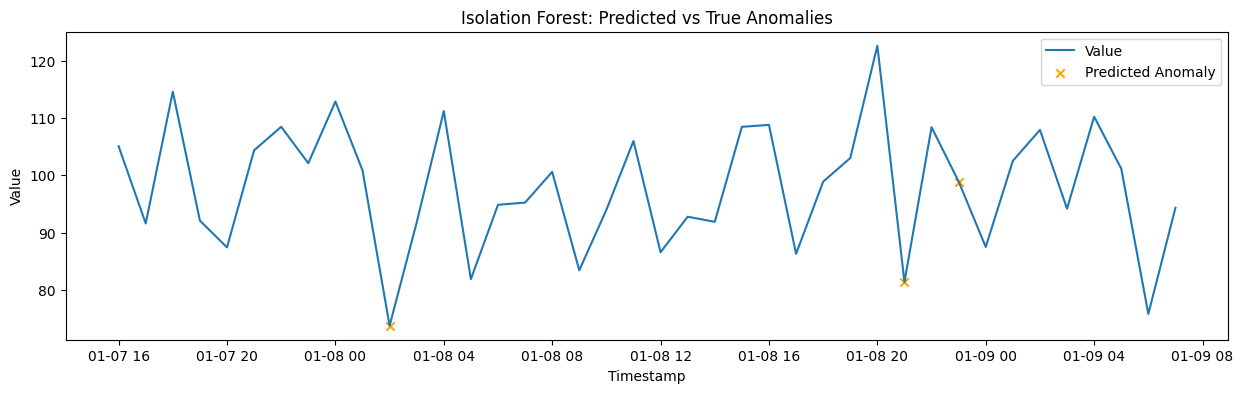

In [5]:
# Advanced ML Modeling for Time Series Anomaly Detection

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Load preprocessed data
data_dir = "../data/processed/aws_cloudwatch_data"
metric_name = "grok_asg"  # Change to your metric file name as needed
csv_path = os.path.join(data_dir, f"{metric_name}_cleaned.csv")
if not os.path.exists(csv_path):
    # Create a dummy DataFrame for testing if file does not exist
    os.makedirs(data_dir, exist_ok=True)
    dummy_dates = pd.date_range(start="2023-01-01", periods=200, freq="H")
    dummy_values = np.random.normal(loc=100, scale=10, size=200)
    dummy_labels = np.zeros(200, dtype=int)
    # Randomly assign some anomalies
    anomaly_indices = np.random.choice(200, size=5, replace=False)
    dummy_labels[anomaly_indices] = 1
    dummy_df = pd.DataFrame({
        "timestamp": dummy_dates,
        "value": dummy_values,
        "label": dummy_labels
    })
    dummy_df.to_csv(csv_path, index=False)
df = pd.read_csv(csv_path, parse_dates=['timestamp'])

# ---- Feature Engineering ----
df = df.sort_values('timestamp')
df['rolling_mean'] = df['value'].rolling(24, min_periods=1).mean()
df['rolling_std'] = df['value'].rolling(24, min_periods=1).std().fillna(0)
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

features = ['value', 'rolling_mean', 'rolling_std', 'hour', 'dayofweek']
X = df[features].fillna(0)

# ---- Train/Test Split ----
test_frac = 0.2
n_test = int(len(df) * test_frac)
X_train, X_test = X[:-n_test], X[-n_test:]
df_train, df_test = df[:-n_test], df[-n_test:]

# ---- Feature Scaling ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Isolation Forest ----
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(X_train_scaled)
test_scores = iso.decision_function(X_test_scaled)
test_preds = iso.predict(X_test_scaled)
test_preds = (test_preds == -1).astype(int)
df_test['pred_anomaly_iforest'] = test_preds

# ---- Evaluation ----
if 'label' in df_test.columns:
    y_true = df_test['label'].values
    y_pred = df_test['pred_anomaly_iforest'].values
    print("Isolation Forest on test set:")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ---- Visualization ----
plt.figure(figsize=(15,4))
plt.plot(df_test['timestamp'], df_test['value'], label='Value')
plt.scatter(df_test.loc[df_test['pred_anomaly_iforest']==1, 'timestamp'],
            df_test.loc[df_test['pred_anomaly_iforest']==1, 'value'],
            color='orange', marker='x', label='Predicted Anomaly')
if 'label' in df_test.columns and df_test['label'].sum()>0:
    plt.scatter(df_test.loc[df_test['label']==1, 'timestamp'],
                df_test.loc[df_test['label']==1, 'value'],
                color='red', marker='o', facecolors='none', label='True Anomaly')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.title("Isolation Forest: Predicted vs True Anomalies")
plt.show()

# ---- (Optional) Try Other Models ----
# For example: One-Class SVM, Autoencoder, LSTM, etc.
